In [1]:
import torchvision
import torch.nn as nn
import torch
import torch.nn.functional as F
from torchvision import transforms,models,datasets
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from torch import optim
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import cv2, glob, numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob
!pip install torchsummary

In [2]:
train_data_dir = '/kaggle/input/cat-and-dog/training_set/training_set'
test_data_dir = '/kaggle/input/cat-and-dog/test_set/test_set'

In [3]:
from torch.utils.data import DataLoader, Dataset
class cats_dogs(Dataset):
    def __init__(self, folder):
        cats = glob(folder+'/cats/*.jpg')
        dogs = glob(folder+'/dogs/*.jpg')
        self.fpaths = cats + dogs
        from random import shuffle, seed; seed(10); shuffle(self.fpaths)
        self.targets = [fpath.split('/')[-1].startswith('dog') for fpath in self.fpaths] # dog=1 & cat=0
    def __len__(self): return len(self.fpaths)
    def __getitem__(self, ix):
        f = self.fpaths[ix]
        target = self.targets[ix]
        im = (cv2.imread(f)[:,:,::-1])
        im = cv2.resize(im, (224,224))
        return torch.tensor(im/255).permute(2,0,1).to(device).float(), torch.tensor([target]).float().to(device)


tensor([1.], device='cuda:0')


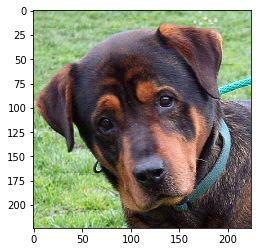

In [4]:
data = cats_dogs(train_data_dir)
im, label = data[200]
plt.imshow(im.permute(1,2,0).cpu())
print(label)

In [5]:
def conv_layer(ni,no,kernel_size,stride=1):
    return nn.Sequential(
    nn.Conv2d(ni, no, kernel_size, stride),
    nn.ReLU(),
    nn.BatchNorm2d(no),
    nn.MaxPool2d(2)
)
def get_model(**kwargs):
    model = nn.Sequential(
        conv_layer(3, 64, 3),
        conv_layer(64, 512, 3),
        conv_layer(512, 512, 3),
        conv_layer(512, 512, 3),
        conv_layer(512, 512, 3),
        conv_layer(512, 512, 3),
        nn.Flatten(),
        nn.Linear(512, 1),
        nn.Sigmoid(),
    ).to(device)
    loss_fn = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=kwargs.get('lr', 1e-3))
    return model, loss_fn, optimizer

from torchsummary import summary
model, loss_fn, optimizer = get_model()
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 222, 222]           1,792
              ReLU-2         [-1, 64, 222, 222]               0
       BatchNorm2d-3         [-1, 64, 222, 222]             128
         MaxPool2d-4         [-1, 64, 111, 111]               0
            Conv2d-5        [-1, 512, 109, 109]         295,424
              ReLU-6        [-1, 512, 109, 109]               0
       BatchNorm2d-7        [-1, 512, 109, 109]           1,024
         MaxPool2d-8          [-1, 512, 54, 54]               0
            Conv2d-9          [-1, 512, 52, 52]       2,359,808
             ReLU-10          [-1, 512, 52, 52]               0
      BatchNorm2d-11          [-1, 512, 52, 52]           1,024
        MaxPool2d-12          [-1, 512, 26, 26]               0
           Conv2d-13          [-1, 512, 24, 24]       2,359,808
             ReLU-14          [-1, 512,

In [6]:
from torch.utils.data import DataLoader, TensorDataset
trn_dl = DataLoader(cats_dogs(train_data_dir), batch_size=32, drop_last=True)
model, loss_fn, optimizer = get_model()
test_dl = DataLoader(cats_dogs(test_data_dir), batch_size=32, drop_last=True)
train_loss, trn_acc, test_acc = [], [], []

0
1
2


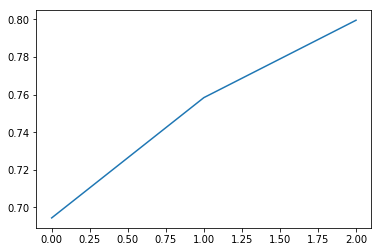

In [7]:
def train_batch(x, y, model, opt, loss_fn):
    prediction = model(x)
    is_correct = (prediction > 0.5) == y
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item(), is_correct

train_losses, val_losses, train_acc, val_acc = [], [], [], []
for epoch in range(3):
    print(epoch)
    N_trn = len(trn_dl)
    for ix, batch in enumerate(trn_dl):
        x, y = batch
        batch_loss, corrects = train_batch(x, y, model, optimizer, loss_fn)
        train_acc.extend(corrects.tolist())
        train_losses.append(batch_loss)
        print(f'Train: {ix}/{N_trn}: {batch_loss:.3f}', end='\r')

    corr = []
    for ix, batch in enumerate(iter(test_dl)):
        x, y = batch
        corr.append(((model(x)>0.5) == y).cpu().detach().numpy())
        print(f'Valid: {ix}/{N_trn}: {batch_loss:.3f}', end='\r')
    val_acc.append(np.mean(np.array(corr)))
plt.plot(val_acc)